In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score
import scipy.io
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [10]:
df = pd.read_csv("../data/data.csv")
df.head(10)

,id,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,0,Thompson,tube,7.00,3770.0,0.1754,NaN,10.8,432.0,3.6
1,1,Thompson,tube,NaN,6049.0,-0.0416,10.3,10.3,762.0,6.2
2,2,Thompson,NaN,13.79,2034.0,0.0335,7.7,7.7,457.0,2.5
3,3,Beus,annulus,13.79,3679.0,-0.0279,5.6,15.2,2134.0,3.0
4,4,NaN,tube,13.79,686.0,NaN,11.1,11.1,457.0,2.8
5,5,NaN,NaN,17.24,3648.0,-0.0711,NaN,1.9,696.0,3.6
6,6,Thompson,NaN,6.89,549.0,0.1203,12.8,12.8,1930.0,2.6
7,7,Peskov,tube,18.00,750.0,NaN,10.0,10.0,1650.0,2.2
8,8,NaN,tube,12.07,4042.0,-0.0536,NaN,NaN,152.0,5.6
9,9,Peskov,tube,12.00,1617.0,0.1228,10.0,10.0,520.0,2.2


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31644 entries, 0 to 31643
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   31644 non-null  int64  
 1   author               26620 non-null  object 
 2   geometry             26144 non-null  object 
 3   pressure [MPa]       27192 non-null  float64
 4   mass_flux [kg/m2-s]  26853 non-null  float64
 5   x_e_out [-]          21229 non-null  float64
 6   D_e [mm]             26156 non-null  float64
 7   D_h [mm]             27055 non-null  float64
 8   length [mm]          26885 non-null  float64
 9   chf_exp [MW/m2]      31644 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 2.4+ MB


In [4]:
# Definir un diccionario de mapeo para los valores conocidos de "author" y "geometry"
mapeo_geometry = {
    'Thompson': 'tube',
    'Peskov': 'tube',
    'Weatherhead': 'tube',
    'Inasaka': 'tube',
    'Williams': 'tube',
    'Beus': 'annulus',
    'Janssen': 'annulus',
    'Mortimore': 'annulus',
    'Richenderfer': 'plate',
    'Kossolapov': 'plate'
}

# Rellenar los valores nulos en "geometry" utilizando el diccionario de mapeo
df['geometry'] = df['geometry'].fillna(df['author'].map(mapeo_geometry))

In [5]:
# Llenar los nulos en "length [mm]" con 10.0 cuando la columna "geometry" es "plate"
df.loc[df['geometry'] == 'plate', 'length [mm]'] = df.loc[df['geometry'] == 'plate', 'length [mm]'].fillna(10.0)

# Llenar los nulos en "D_e [mm]" con 15.0 cuando la columna "geometry" es "plate"
df.loc[df['geometry'] == 'plate', 'D_e [mm]'] = df.loc[df['geometry'] == 'plate', 'D_e [mm]'].fillna(15.0)

# Llenar los nulos en "D_h [mm]" con 120.0 cuando la columna "geometry" es "plate"
df.loc[df['geometry'] == 'plate', 'D_h [mm]'] = df.loc[df['geometry'] == 'plate', 'D_h [mm]'].fillna(120.0)


In [8]:
# Agrupar por "author" y "geometry" y obtener los valores únicos
unique_values = df.groupby(['author', 'geometry']).size().reset_index()

# Mostrar los valores únicos para cada grupo
print(unique_values)

          author geometry      0
0           Beus  annulus   1575
1           Beus     tube     29
2        Inasaka    plate      1
3        Inasaka     tube     45
4        Janssen  annulus   2684
5        Janssen    plate      1
6        Janssen     tube     31
7     Kossolapov  annulus      1
8     Kossolapov    plate     97
9     Kossolapov     tube      3
10     Mortimore  annulus    189
11     Mortimore    plate      2
12     Mortimore     tube      6
13        Peskov  annulus      1
14        Peskov    plate      3
15        Peskov     tube   1080
16  Richenderfer  annulus      6
17  Richenderfer    plate    504
18  Richenderfer     tube     35
19      Thompson  annulus      9
20      Thompson    plate     11
21      Thompson     tube  17376
22   Weatherhead  annulus      1
23   Weatherhead     tube   2039
24      Williams  annulus      1
25      Williams    plate      1
26      Williams     tube    889


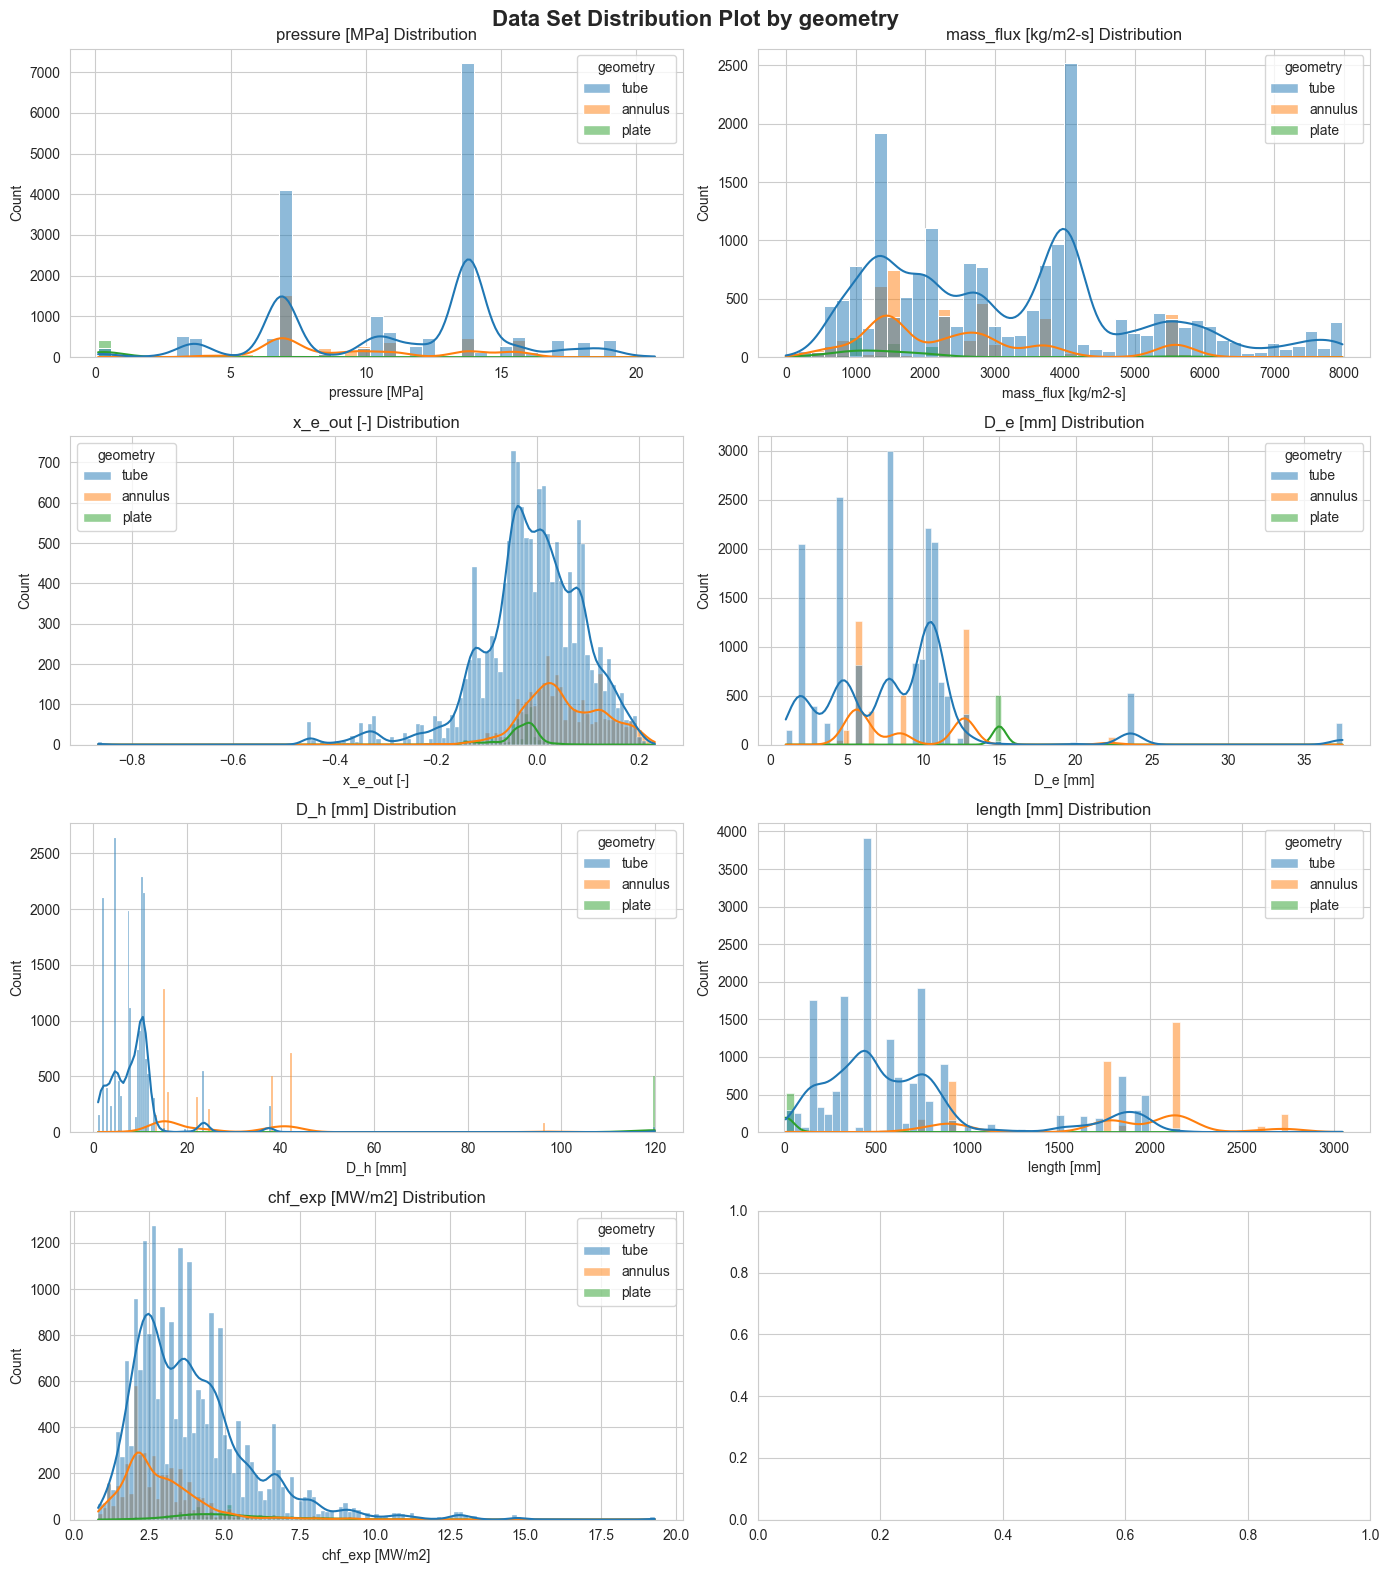

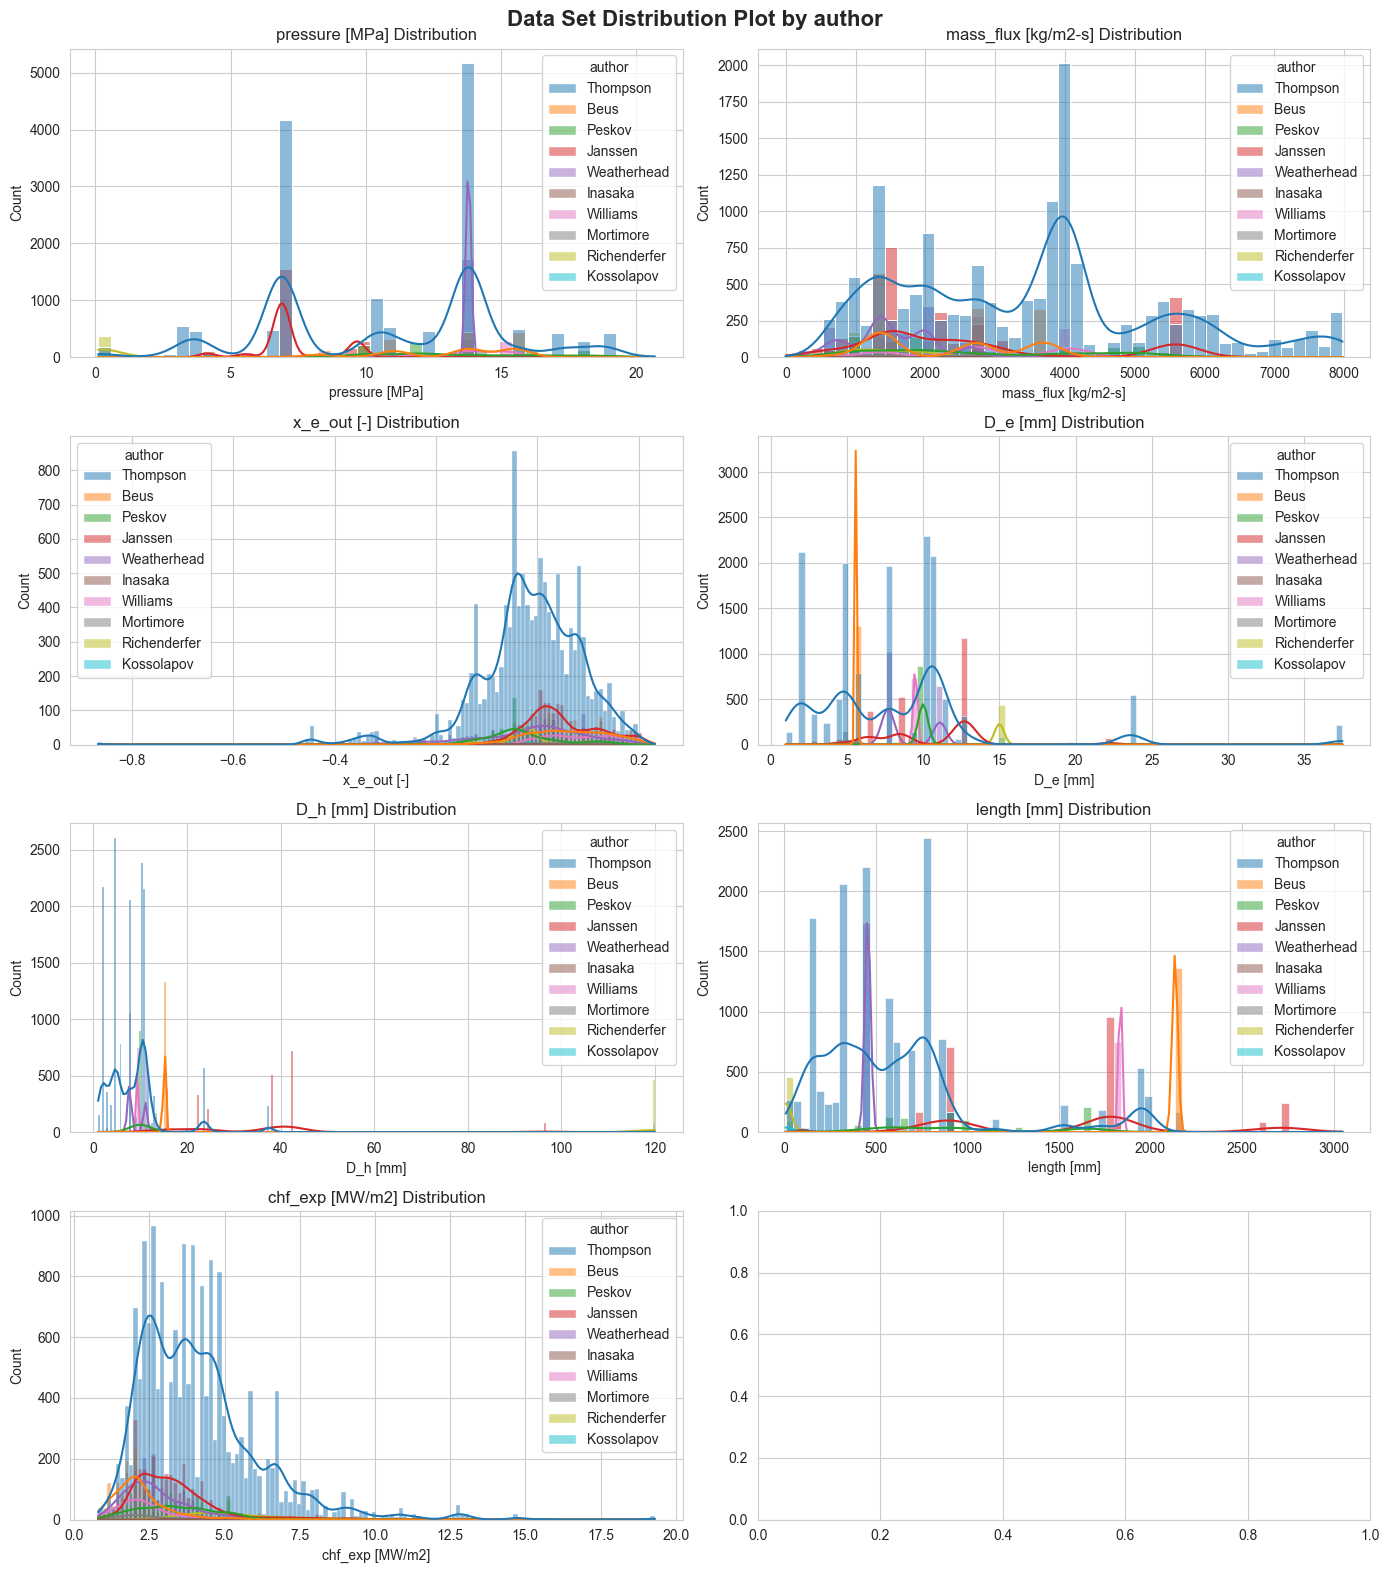

In [14]:
def plot_distribution(df, hue, title='', drop_cols=[]):
    sns.set_style('whitegrid')

    cols = df.columns.drop([hue] + drop_cols)
    n_cols = 2
    n_rows = (len(cols) - 1) // n_cols + 1

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, 4*n_rows))

    for i, var_name in enumerate(cols):
        row = i // n_cols
        col = i % n_cols

        ax = axes[row, col]
        sns.histplot(data=df, x=var_name, kde=True, ax=ax, hue=hue) # sns.distplot(df_train[var_name], kde=True, ax=ax, label='Train')
        ax.set_title(f'{var_name} Distribution')

    fig.suptitle(f'{title} Distribution Plot by {hue}', fontweight='bold', fontsize=16)
    plt.tight_layout()
    plt.show()

plot_distribution(df, hue='geometry', title='Data Set', drop_cols=['id', 'author'])
plot_distribution(df, hue='author', title='Data Set', drop_cols=['id', 'geometry'])

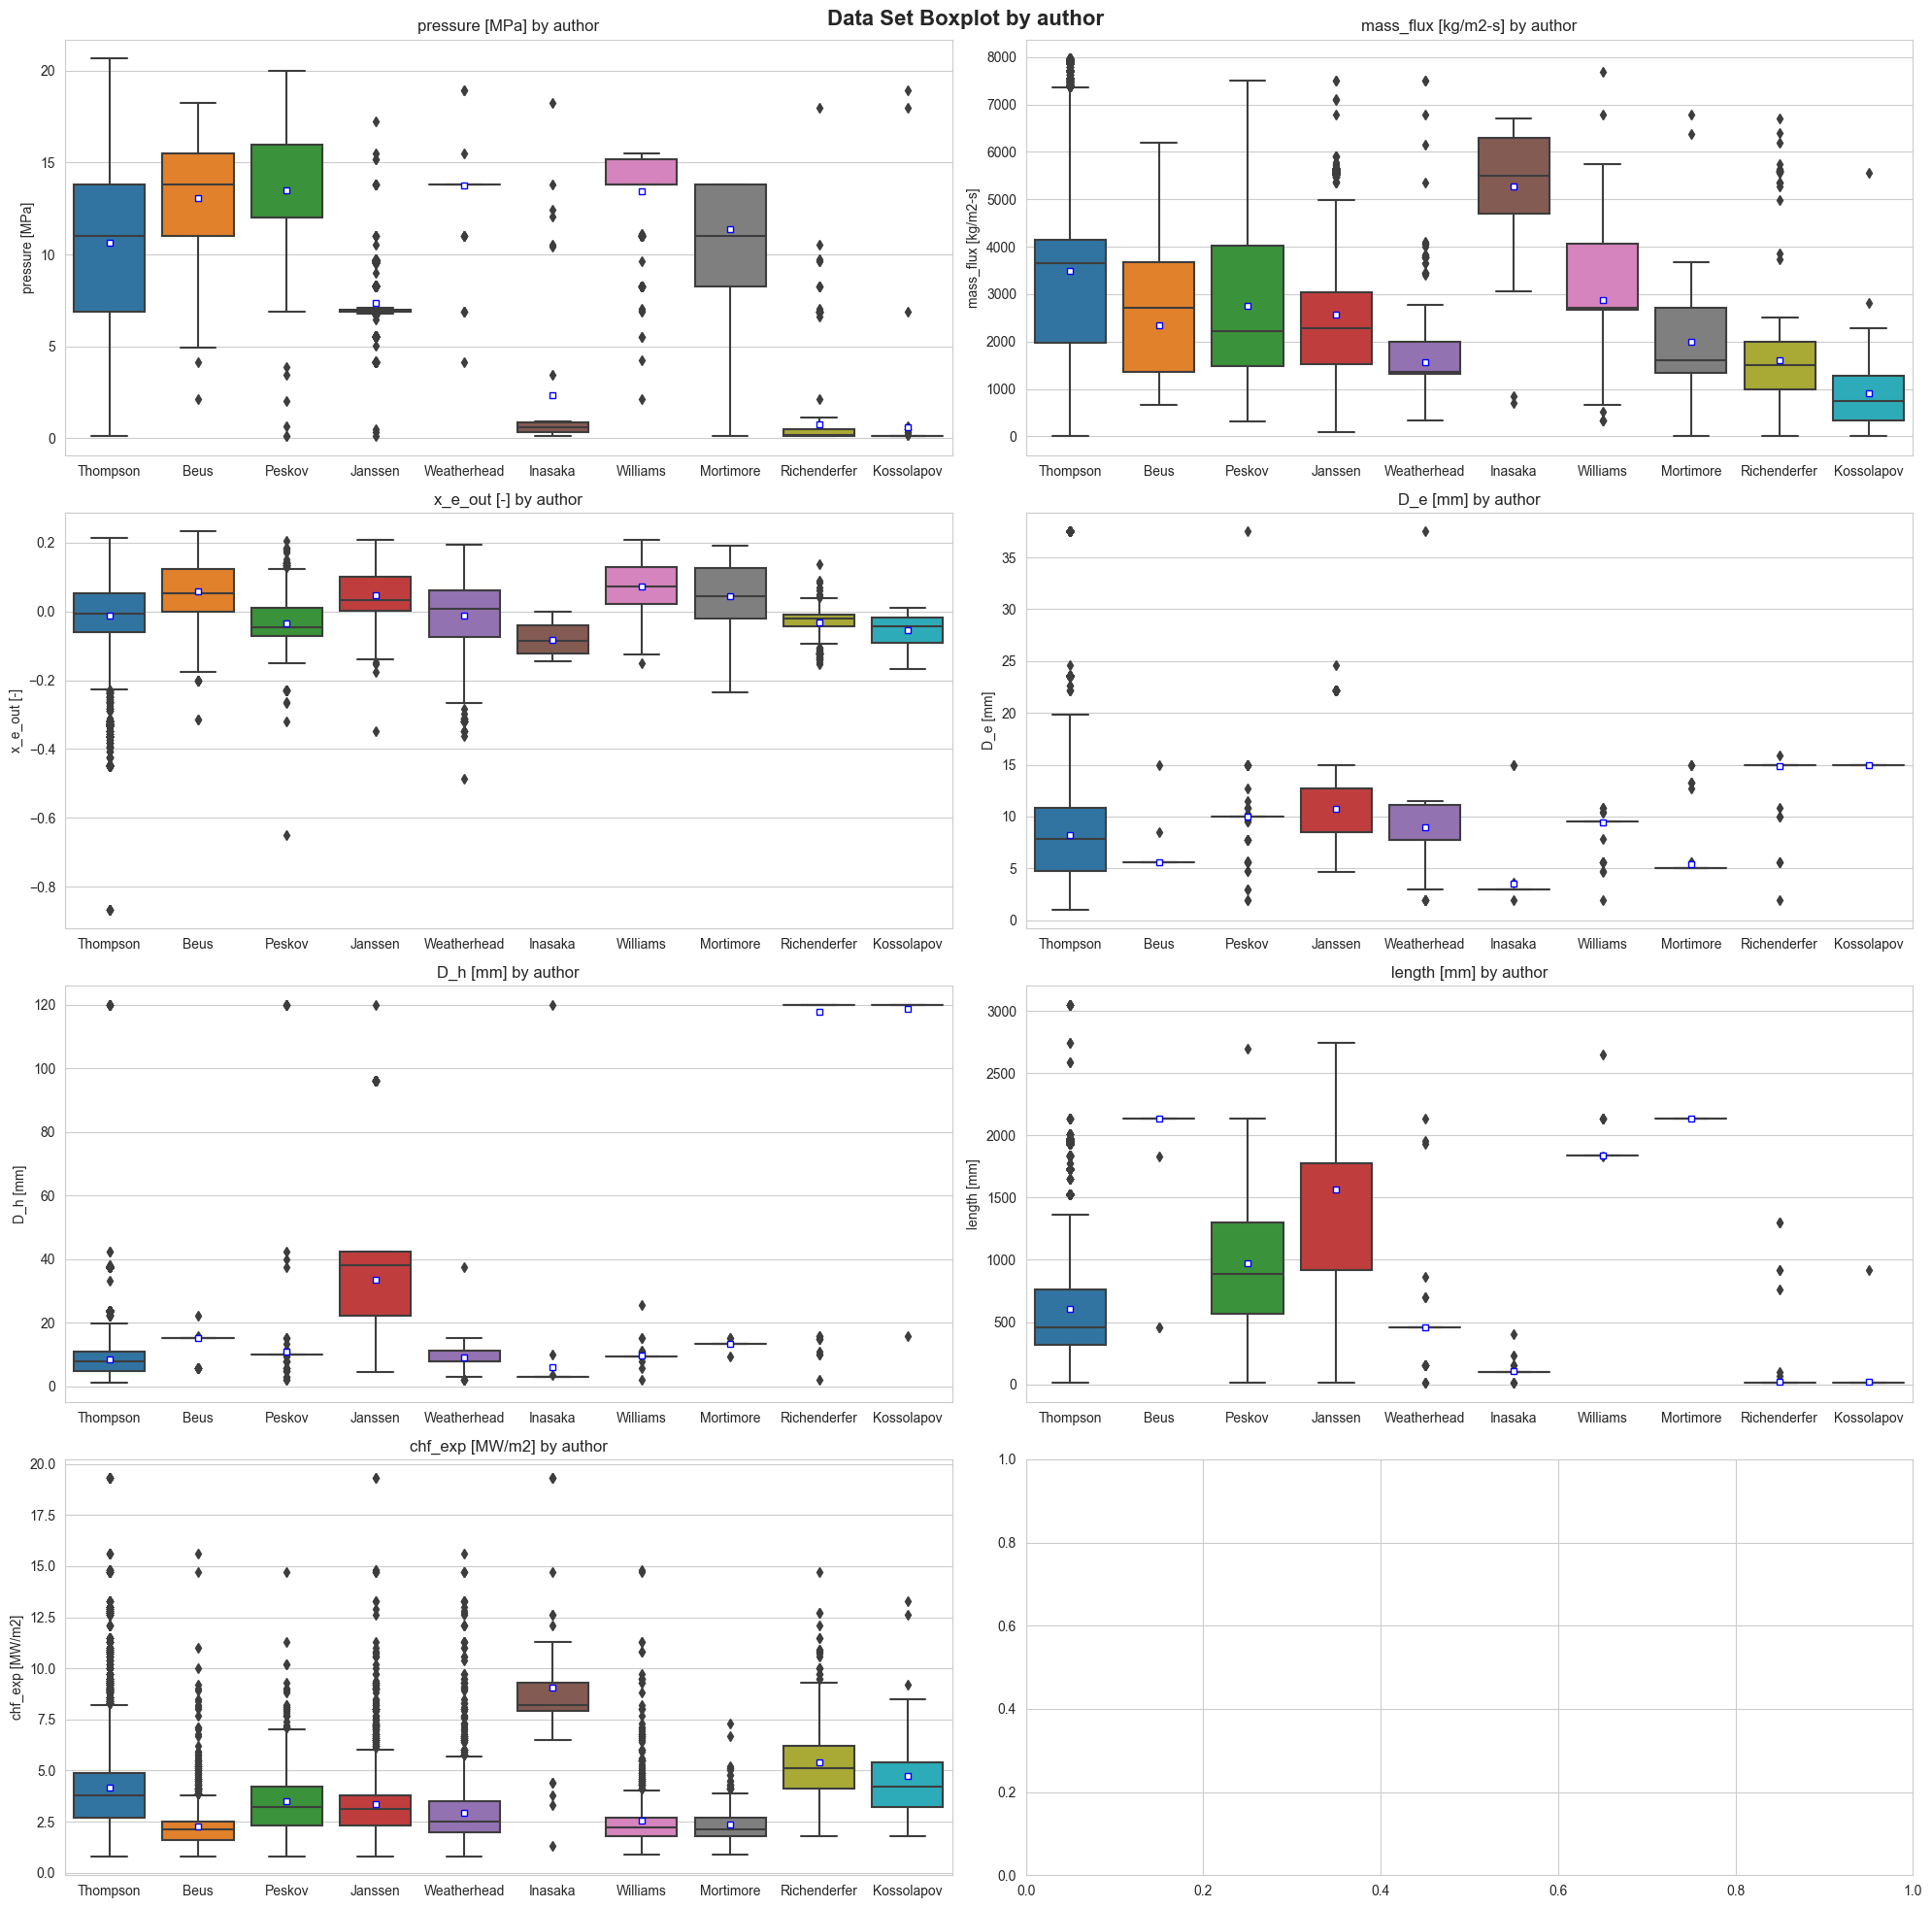

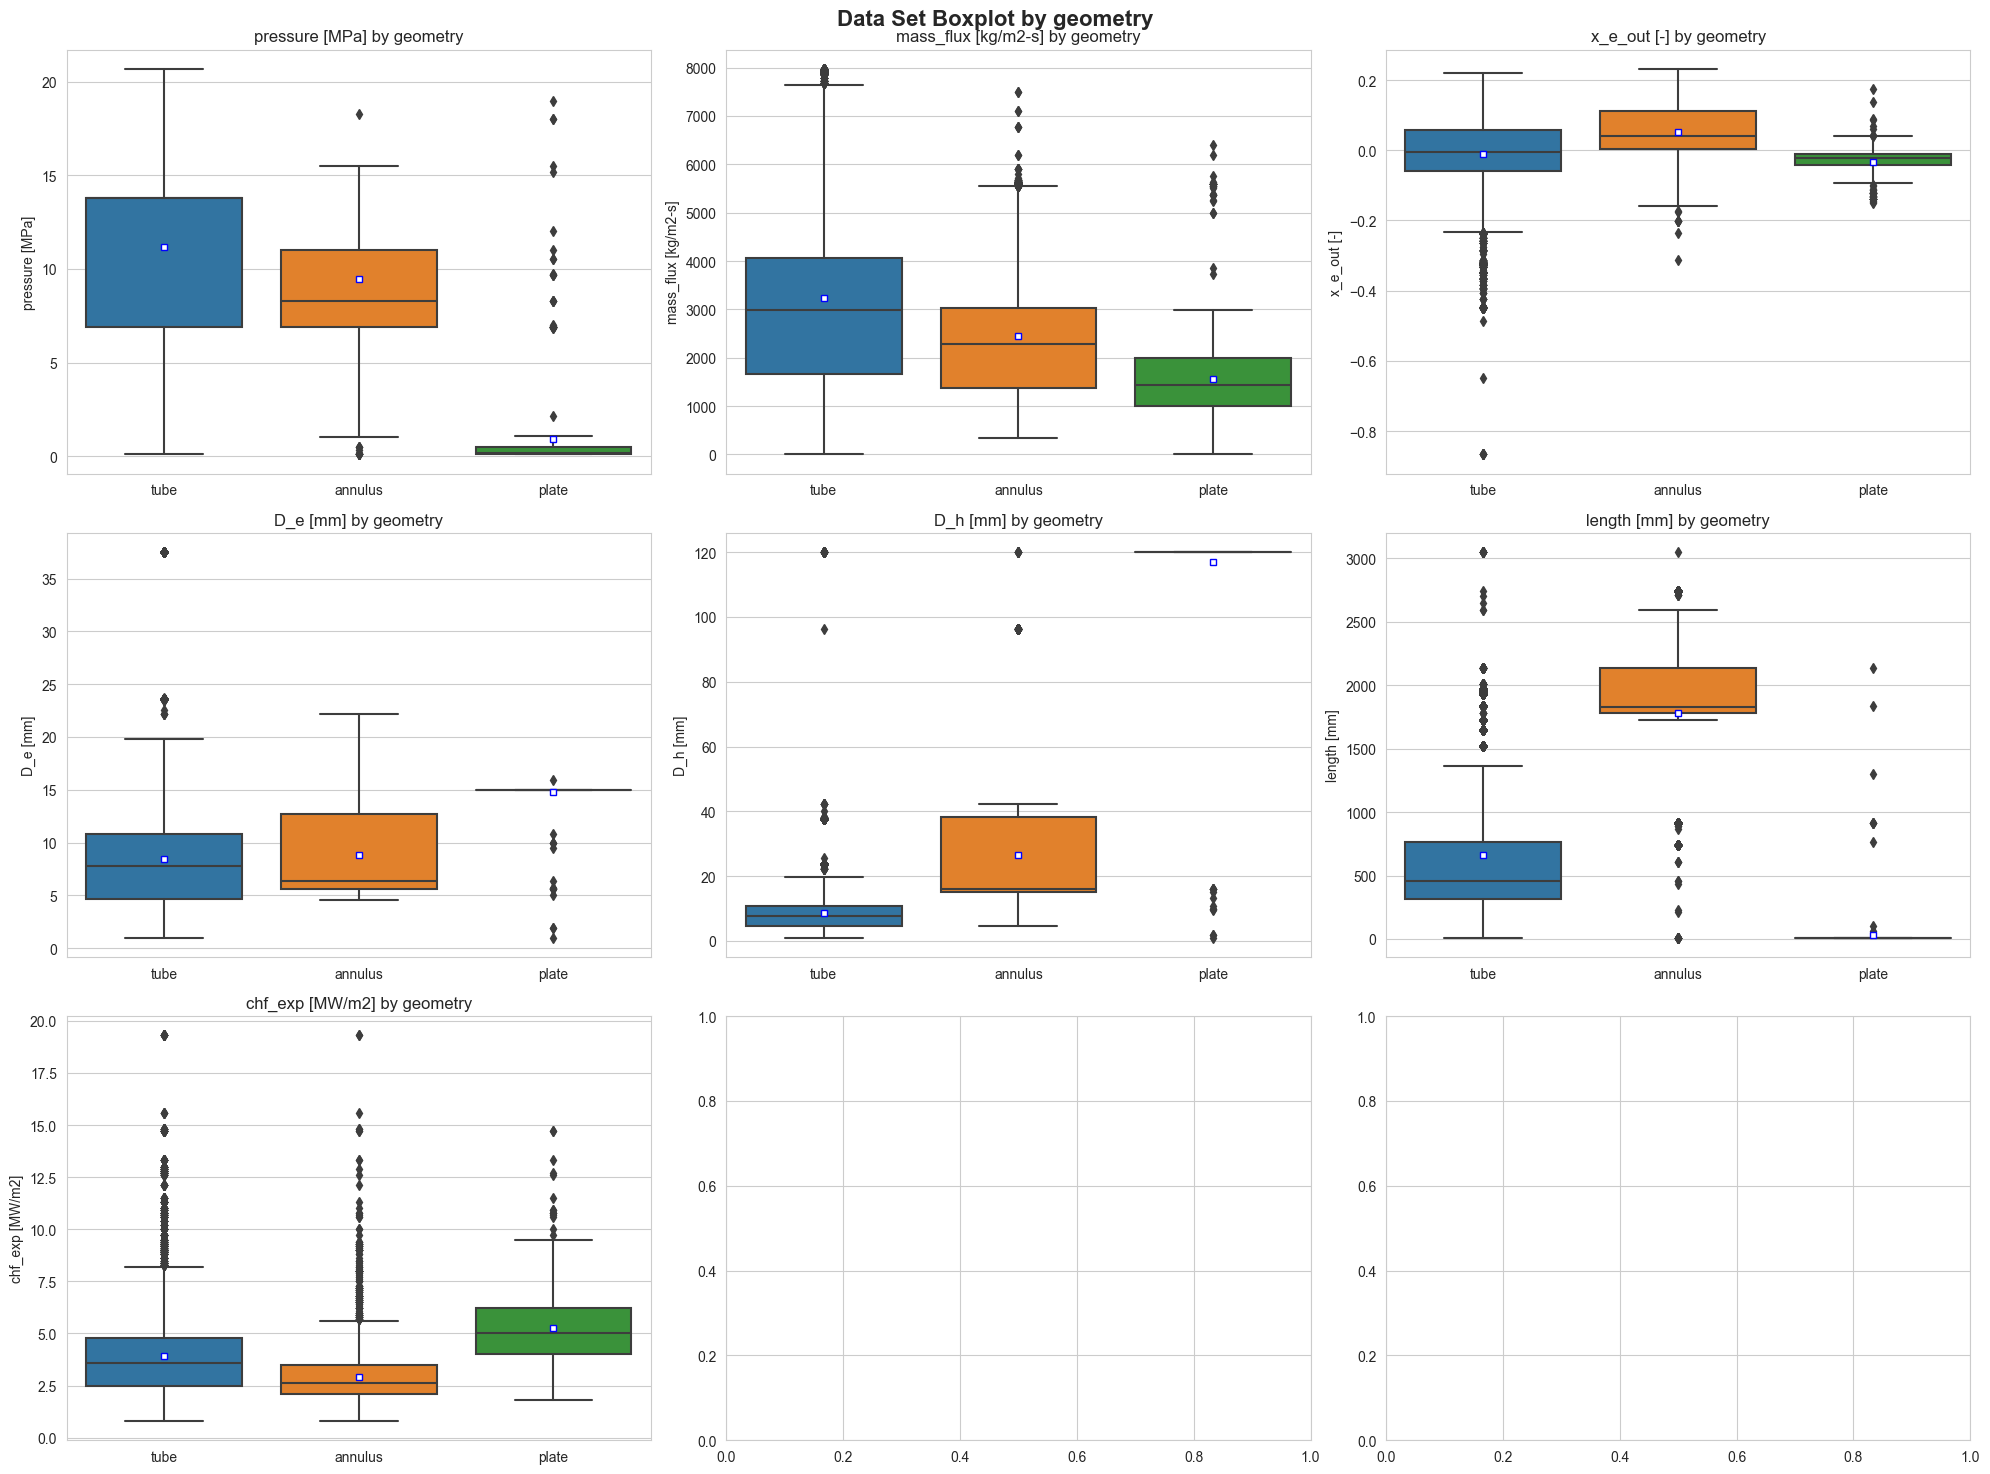

In [15]:
def plot_boxplot(df, hue, title='', drop_cols=[], n_cols=3):
    sns.set_style('whitegrid')

    cols = df.columns.drop([hue] + drop_cols)
    n_rows = (len(cols) - 1) // n_cols + 1

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5*n_rows))

    for i, var_name in enumerate(cols):
        row = i // n_cols
        col = i % n_cols

        ax = axes[row, col]
        sns.boxplot(data=df, x=hue, y=var_name, ax=ax, showmeans=True, 
                    meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue", "markersize":"5"})
        ax.set_title(f'{var_name} by {hue}')
        ax.set_xlabel('')

    fig.suptitle(f'{title} Boxplot by {hue}', fontweight='bold', fontsize=16)
    plt.tight_layout()
    plt.show()

plot_boxplot(df, hue='author', title='Data Set', drop_cols=['id', 'geometry'], n_cols=2)
plot_boxplot(df, hue='geometry', title='Data Set', drop_cols=['id', 'author'], n_cols=3)


In [6]:
# Filtrar las filas con valores nulos en la columna 'x_e_out'
df_nulos = df[df['x_e_out [-]'].isnull()]

# Crear un nuevo DataFrame con las filas que contienen valores nulos en 'x_e_out'
nuevos_datos = df_nulos.copy()

In [7]:
df = df.dropna(subset=['x_e_out [-]'])

# Imprimir el DataFrame original sin las filas con valores nulos

In [8]:
df['geometry'] = df['geometry'].fillna('tube')

In [9]:
# Definir un diccionario de mapeo para los valores conocidos de "author" y "geometry"
mapeo_geometry = {
    'Thompson': 'tube',
    'Peskov': 'tube',
    'Weatherhead': 'tube',
    'Inasaka': 'tube',
    'Williams': 'tube',
    'Beus': 'annulus',
    'Janssen': 'annulus',
    'Mortimore': 'annulus',
    'Richenderfer': 'plate',
    'Kossolapov': 'plate'
}

# Rellenar los valores nulos en "geometry" utilizando el diccionario de mapeo
nuevos_datos['geometry'] = nuevos_datos['geometry'].fillna(nuevos_datos['author'].map(mapeo_geometry))

In [10]:
nuevos_datos['geometry'] = nuevos_datos['geometry'].fillna('tube')

In [16]:
df.loc[df['geometry'] == 'tube', 'author'] = df.loc[df['geometry'] == 'tube', 'author'].fillna('Thompson')
df.loc[df['geometry'] == 'plate', 'author'] = df.loc[df['geometry'] == 'plate', 'author'].fillna('Richenderfer')
df.loc[df['geometry'] == 'annulus', 'author'] = df.loc[df['geometry'] == 'annulus', 'author'].fillna('Beus')

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [18]:
nuevos_datos.loc[nuevos_datos['geometry'] == 'tube', 'author'] = nuevos_datos.loc[nuevos_datos['geometry'] == 'tube', 'author'].fillna('Thompson')
nuevos_datos.loc[nuevos_datos['geometry'] == 'plate', 'author'] = nuevos_datos.loc[nuevos_datos['geometry'] == 'plate', 'author'].fillna('Richenderfer')
nuevos_datos.loc[nuevos_datos['geometry'] == 'annulus', 'author'] = nuevos_datos.loc[nuevos_datos['geometry'] == 'annulus', 'author'].fillna('Beus')

In [19]:
# Aplicar codificación one-hot a la columna "author"
df = pd.get_dummies(df, columns=['author'], prefix=['author'])

# Aplicar codificación one-hot a la columna "geometry"
df = pd.get_dummies(df, columns=['geometry'], prefix=['geometry'])

# Aplicar codificación one-hot a la columna "author"
nuevos_datos = pd.get_dummies(nuevos_datos, columns=['author'], prefix=['author'])

# Aplicar codificación one-hot a la columna "geometry"
nuevos_datos = pd.get_dummies(nuevos_datos, columns=['geometry'], prefix=['geometry'])

In [20]:
# Dividir en X e y
X = df.drop(['x_e_out [-]', 'id'], axis=1)  # Todas las columnas excepto 'x_e_out'
y = df['x_e_out [-]']  # Solo la columna 'x_e_out

In [21]:
# Separar las características (X) y la columna objetivo (y)
X_nuevos_datos = nuevos_datos.drop(columns=["x_e_out [-]"])
y_nuevos_datos = nuevos_datos["x_e_out [-]"]

In [22]:
X.rename(columns={'pressure [MPa]': 'pressure', 'mass_flux [kg/m2-s]': 'mass_flux', 
                    'D_e [mm]': 'D_e', 'D_h [mm]': 'D_h', 'length [mm]': 'length'
                    , 'chf_exp [MW/m2]': 'chf_exp'}, inplace=True)

y.name = 'x_e_out'

In [23]:
X_nuevos_datos.rename(columns={'pressure [MPa]': 'pressure', 'mass_flux [kg/m2-s]': 'mass_flux', 
                    'D_e [mm]': 'D_e', 'D_h [mm]': 'D_h', 'length [mm]': 'length'
                    , 'chf_exp [MW/m2]': 'chf_exp'}, inplace=True)


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
df_additional = pd.read_csv('data/Data_CHF_Zhao_2020_ATE.csv')

In [26]:
# Aplicar codificación one-hot a la columna "author"
df_additional = pd.get_dummies(df_additional, columns=['author'], prefix=['author'])

# Aplicar codificación one-hot a la columna "geometry"
df_additional = pd.get_dummies(df_additional, columns=['geometry'], prefix=['geometry'])

In [27]:
# Dividir en X e y
X_additional = df_additional.drop(['x_e_out [-]', 'id'], axis=1)  # Todas las columnas excepto 'x_e_out'
Y_additional = df_additional['x_e_out [-]']  # Solo la columna 'x_e_out

In [28]:
X_additional.rename(columns={'pressure [MPa]': 'pressure', 'mass_flux [kg/m2-s]': 'mass_flux', 
                    'D_e [mm]': 'D_e', 'D_h [mm]': 'D_h', 'length [mm]': 'length'
                    , 'chf_exp [MW/m2]': 'chf_exp'}, inplace=True)

Y_additional.name = 'x_e_out'

In [30]:
# Paso 4: Concatenar X_additional y y_additional a X_train y y_train
X_train = np.concatenate((X_train, X_additional), axis=0)
y_train = np.concatenate((y_train, Y_additional), axis=0)


AttributeError: 'numpy.ndarray' object has no attribute 'info'

In [ ]:
#Separar las características (X) y la columna objetivo (y)
X_nuevos_datos = nuevos_datos.drop(columns=["x_e_out [-]"])
y_nuevos_datos = nuevos_datos["x_e_out [-]"]

# Imputar los valores nulos en las características (X)
imputer = KNNImputer(n_neighbors=5)
X_nuevos_datos_imputed = imputer.fit_transform(X_nuevos_datos)

#Separar las características (X) y la columna objetivo (y)
X_nuevos_datos = nuevos_datos.drop(columns=["x_e_out [-]"])
y_nuevos_datos = nuevos_datos["x_e_out [-]"]


# Convertir el resultado a DataFrame
X_nuevos_datos_imputed = pd.DataFrame(X_nuevos_datos_imputed, columns=X_nuevos_datos.columns)

In [83]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import KNNImputer


# Paso 4: Concatenar X_additional y y_additional a X_train y y_train
X_train = np.concatenate((X_train, X_additional), axis=0)
y_train = np.concatenate((y_train, Y_additional), axis=0)

# Paso 5: Definir las transformaciones y el modelo
imputer = KNNImputer(n_neighbors=5)
scaler = StandardScaler()
model = XGBRegressor(colsample_bytree=0.5, learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.6)

# Paso 6: Crear el pipeline
xg_pipeline = Pipeline([
    ('imputer', imputer),
    ('scaler', scaler),
    ('model', model)
])

# Paso 7: Ajustar el pipeline a los datos de entrenamiento
xg_pipeline.fit(X_train, y_train)

# Paso 8: Realizar predicciones en los datos de prueba
y_pred = xg_pipeline.predict(X_test)

from sklearn.metrics import mean_squared_error
import math

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calcular el RMSE
rmse = math.sqrt(mse)

print("RMSE:", rmse)

c:\Python311\Lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNNImputer was fitted without feature names
  warnings.warn(


RMSE: 0.07476652530144405


In [52]:
#Separar las características (X) y la columna objetivo (y)
X_nuevos_datos = nuevos_datos.drop(columns=["x_e_out [-]"])
y_nuevos_datos = nuevos_datos["x_e_out [-]"]

# Imputar los valores nulos en las características (X)
imputer = KNNImputer(n_neighbors=5)
X_nuevos_datos_imputed = imputer.fit_transform(X_nuevos_datos)

# Convertir el resultado a DataFrame
X_nuevos_datos_imputed = pd.DataFrame(X_nuevos_datos_imputed, columns=X_nuevos_datos.columns)

# # Crear el objeto de regresión lineal
# regression_model = LinearRegression()


In [43]:
X_nuevos_datos_imputed = X_nuevos_datos_imputed.drop(columns=["id"])

In [47]:

# Realizar predicciones en la columna objetivo (y) para los datos imputados
y_pred1 = xg_pipeline.predict(X_nuevos_datos_imputed)

# Combinar las predicciones con los datos originales
nuevos_datos["x_e_out [-]"] = y_pred1

# Los datos ahora tienen las predicciones en la columna objetivo (y)

# Guardar los datos en un archivo para la competición de Kaggle
nuevos_datos.to_csv("nuevos_datos_con_predicciones2.csv", index=False)

c:\Python311\Lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNNImputer was fitted without feature names
  warnings.warn(


In [48]:
# # Leer el archivo CSV
prueba1 = pd.read_csv("nuevos_datos_con_predicciones2.csv")

# Mantener solo las columnas "id" y "x_e_out [mm]"
columnas_deseadas = ["id", "x_e_out [-]"]
prueba1 = prueba1[columnas_deseadas]

# Guardar el DataFrame resultante en un nuevo archivo CSV
prueba1.to_csv("nuevos_datos_con_predicciones_filtrado10.csv", index=False)

In [99]:
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import math

# Paso 5: Definir las transformaciones y los modelos
imputer = KNNImputer(n_neighbors=5)
scaler = StandardScaler()
rf_model = RandomForestRegressor(max_depth= 12, min_samples_leaf= 5, min_samples_split= 10, n_estimators= 100)
gb_model = GradientBoostingRegressor(max_depth=5, n_estimators=100, learning_rate=0.1)
ada_model = AdaBoostRegressor(n_estimators=100)
et_model = ExtraTreesRegressor(min_samples_split=8, n_estimators= 400)

# Paso 6: Crear los pipelines para Random Forest y Gradient Boosting
rf_pipeline = Pipeline([
    ('imputer', imputer),
    ('scaler', scaler),
    ('model', rf_model)
])

gb_pipeline = Pipeline([
    ('imputer', imputer),
    ('scaler', scaler),
    ('model', gb_model)
])

ada_pipeline = Pipeline([
    ('imputer', imputer),
    ('scaler', scaler),
    ('model', ada_model)
])

et_pipeline = Pipeline([
    ('imputer', imputer),
    ('scaler', scaler),
    ('model', et_model)
])

# Paso 7: Ajustar los pipelines a los datos de entrenamiento
rf_pipeline.fit(X_train, y_train)
gb_pipeline.fit(X_train, y_train)
ada_pipeline.fit(X_train, y_train)
et_pipeline.fit(X_train, y_train)

# Paso 8: Realizar predicciones en los datos de prueba
y_pred_rf = rf_pipeline.predict(X_test)
y_pred_gb = gb_pipeline.predict(X_test)
y_pred_ada = ada_pipeline.predict(X_test)
y_pred_et = et_pipeline.predict(X_test)

# Calcular el error cuadrático medio (MSE) y el RMSE para Random Forest
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = math.sqrt(mse_rf)
print("RMSE (Random Forest):", rmse_rf)

# Calcular el error cuadrático medio (MSE) y el RMSE para Gradient Boosting
mse_gb = mean_squared_error(y_test, y_pred_gb)
rmse_gb = math.sqrt(mse_gb)
print("RMSE (Gradient Boosting):", rmse_gb)

# Calcular el error cuadrático medio (MSE) y el RMSE para AdaBoost
mse_ada = mean_squared_error(y_test, y_pred_ada)
rmse_ada = math.sqrt(mse_ada)
print("RMSE (AdaBoost):", rmse_ada)

# Calcular el error cuadrático medio (MSE) y el RMSE para Extra Trees
mse_et = mean_squared_error(y_test, y_pred_et)
rmse_et = math.sqrt(mse_et)
print("RMSE (Extra Trees):", rmse_et)

c:\Python311\Lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but IterativeImputer was fitted without feature names
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but IterativeImputer was fitted without feature names
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but IterativeImputer was fitted without feature names
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but IterativeImputer was fitted without feature names
  warnings.warn(


RMSE (Random Forest): 0.07819002635166862
RMSE (Gradient Boosting): 0.07666082924356261
RMSE (AdaBoost): 0.09634552137702061
RMSE (Extra Trees): 0.07992261175403133


In [97]:
from sklearn.ensemble import VotingRegressor
voting_reg1 = VotingRegressor([('rf', rf_pipeline), ('XG', xg_pipeline), ('GraBoosst', gb_pipeline), ('ExtraTrees', et_pipeline)], 
                              weights=[3/20, 8/20, 7/20, 2/20])
voting_reg1.fit(X_train, y_train)

VotingRegressor(estimators=[('rf',
                             Pipeline(steps=[('imputer', KNNImputer()),
                                             ('scaler', StandardScaler()),
                                             ('model',
                                              RandomForestRegressor(max_depth=12,
                                                                    min_samples_leaf=5,
                                                                    min_samples_split=10))])),
                            ('XG',
                             Pipeline(steps=[('imputer', KNNImputer()),
                                             ('scaler', StandardScaler()),
                                             ('model',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsample_bylevel...
                                                           predictor=None,
                                                           random_state=None, ...))])),
                            ('GraBoosst',
                             Pipeline(steps=[('imputer', KNNImputer()),
                                             ('scaler', StandardScaler()),
                                             ('model',
                                              GradientBoostingRegressor(max_depth=5))])),
                            ('ExtraTrees',
                             Pipeline(steps=[('imputer', KNNImputer()),
                                             ('scaler', StandardScaler()),
                                             ('model',
                                              ExtraTreesRegressor(min_samples_split=8,
                                                                  n_estimators=400))]))],
                weights=[0.15, 0.4, 0.35, 0.1])

In [98]:
ensamble1=voting_reg1.predict(X_test)


mse = mean_squared_error(y_test, ensamble1)
r2 = r2_score(y_test, ensamble1)

print("Mean Squared Error (MSE): ", mse)
print("R-squared (R2) Score: ", r2)
from math import sqrt

#Calcular el RMSE

rmse = sqrt(mse)
print("Root Mean Squared Error (RMSE): ", rmse)

c:\Python311\Lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNNImputer was fitted without feature names
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNNImputer was fitted without feature names
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNNImputer was fitted without feature names
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNNImputer was fitted without feature names
  warnings.warn(


Mean Squared Error (MSE):  0.0056182599219669355
R-squared (R2) Score:  0.44689067360385704
Root Mean Squared Error (RMSE):  0.07495505267803455


In [77]:
X_nuevos_datos_imputed = X_nuevos_datos_imputed.drop(columns=["id"])

# Realizar predicciones en la columna objetivo (y) para los datos imputados
y_pred1 = voting_reg1.predict(X_nuevos_datos_imputed)

# Combinar las predicciones con los datos originales
nuevos_datos["x_e_out [-]"] = y_pred1

# Los datos ahora tienen las predicciones en la columna objetivo (y)

# Guardar los datos en un archivo para la competición de Kaggle
nuevos_datos.to_csv("nuevos_datos_con_predicciones2.csv", index=False)

c:\Python311\Lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNNImputer was fitted without feature names
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNNImputer was fitted without feature names
  warnings.warn(


In [78]:
# # Leer el archivo CSV
prueba1 = pd.read_csv("nuevos_datos_con_predicciones2.csv")

# Mantener solo las columnas "id" y "x_e_out [mm]"
columnas_deseadas = ["id", "x_e_out [-]"]
prueba1 = prueba1[columnas_deseadas]

# Guardar el DataFrame resultante en un nuevo archivo CSV
prueba1.to_csv("nuevos_datos_con_predicciones_filtrado11.csv", index=False)

In [93]:
from sklearn.impute import KNNImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import math

# Paso 5: Definir las transformaciones y el modelo
imputer = KNNImputer(n_neighbors=5)
scaler = StandardScaler()
et_model = ExtraTreesRegressor()

# Paso 6: Crear el pipeline
et_pipeline = Pipeline([
    ('imputer', imputer),
    ('scaler', scaler),
    ('model', et_model)
])

# Paso 7: Definir los parámetros de búsqueda en malla
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 5, 10],
    'model__min_samples_split': [2, 4, 6]
}

# Paso 8: Realizar la búsqueda en malla con validación cruzada
grid_search = GridSearchCV(et_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Mejor modelo encontrado
best_model = grid_search.best_estimator_

# Paso 9: Realizar predicciones en los datos de prueba con el mejor modelo
y_pred = best_model.predict(X_test)

# Calcular el error cuadrático medio (MSE) y el RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
print("RMSE:", rmse)

Mejores hiperparámetros: {'model__max_depth': None, 'model__min_samples_split': 6, 'model__n_estimators': 300}


c:\Python311\Lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNNImputer was fitted without feature names
  warnings.warn(


RMSE: 0.0810616503928035


In [ ]:
from sklearn.impute import KNNImputer
from sklearn.ensemble import AdaBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import math

# Paso 5: Definir las transformaciones y el modelo
imputer = KNNImputer(n_neighbors=5)
scaler = StandardScaler()
ada_model = AdaBoostRegressor()

# Paso 6: Crear el pipeline
ada_pipeline = Pipeline([
    ('imputer', imputer),
    ('scaler', scaler),
    ('model', ada_model)
])

# Paso 7: Definir los parámetros de búsqueda en malla
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 1.0],
}

# Paso 8: Realizar la búsqueda en malla con validación cruzada
grid_search = GridSearchCV(ada_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Mejor modelo encontrado
best_model = grid_search.best_estimator_

# Paso 9: Realizar predicciones en los datos de prueba con el mejor modelo
y_pred = best_model.predict(X_test)

# Calcular el error cuadrático medio (MSE) y el RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
print("RMSE:", rmse)